Read in the necessary libraries

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns

Read in the necessary data

In [93]:
df_detailed_listings = pd.read_csv('./resource/detailed_listings.csv')


In [94]:
df_detailed_listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

The raw data containes a lot of information we do not want to process or use for predicting any features, so we drop them. For our purpose features which contain for example urls or similar should be droped befor starting to analyze the data.

In [95]:
df_listing_cleaned = df_detailed_listings.drop(columns=['listing_url', 'scrape_id', 'last_scraped', 'source', 'picture_url', 'host_url', \
                                      'host_thumbnail_url', 'host_picture_url', 'latitude', 'longitude', 'calendar_updated', \
                                      'calendar_last_scraped', 'license'], axis=1).copy()

Furthermore there are also columns which contain no or way to few values to be valuable to our predictions and analysis. So they are droped as well.

In [96]:
# Searching for columns missing all data:
print(df_listing_cleaned.loc[:, df_listing_cleaned.isnull().all()].columns)

# drop columns which have no values
print(len(df_listing_cleaned.columns))
df_listing_cleaned = df_listing_cleaned.dropna(axis=1, how='all')
print(len(df_listing_cleaned.columns))

# df_listing_cleaned = df_listing_cleaned.drop(columns=['bathrooms'], axis=1).copy()

Index(['bathrooms'], dtype='object')
62
61


In [97]:
df_listing_cleaned.neighbourhood_group_cleansed.unique()

array(['Pankow', 'Friedrichshain-Kreuzberg', 'Mitte',
       'Treptow - Köpenick', 'Neukölln', 'Tempelhof - Schöneberg',
       'Charlottenburg-Wilm.', 'Marzahn - Hellersdorf',
       'Steglitz - Zehlendorf', 'Spandau', 'Reinickendorf', 'Lichtenberg'],
      dtype=object)

In [98]:
df_listing_cleaned.price.head()

0     $83.00
1    $180.00
2    $280.00
3     $70.00
4    $135.00
Name: price, dtype: object

In [99]:
df_listing_cleaned['price'] = df_listing_cleaned.price.str[1:].str.replace(',','').str.split('.').str[0].astype(int)

In [100]:
df_listing_cleaned.price.head()

0     83
1    180
2    280
3     70
4    135
Name: price, dtype: int64

In [101]:
df_analyze_q1 = df_listing_cleaned.groupby(['neighbourhood_group_cleansed'], as_index=False).aggregate(beds=('beds','mean'), price=('price','mean')).sort_values(by='price',ascending=False)

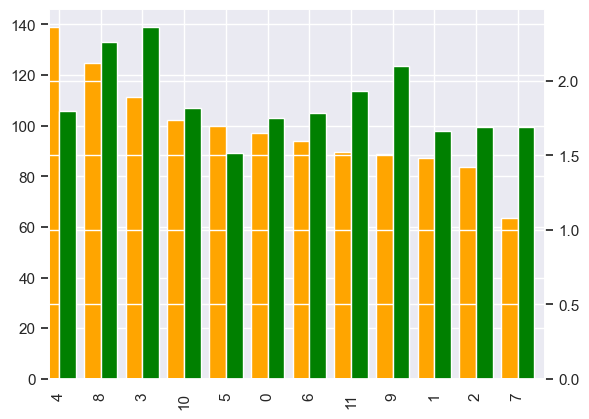

In [102]:
fig = plt.figure()

ax = fig.add_subplot()
ax2 = ax.twinx()

df_analyze_q1.price.plot(kind='bar', ax=ax, width=0.4, position=1, color='orange')
df_analyze_q1.beds.plot(kind='bar', ax=ax2, width=0.4, position=0, color='green')


plt.show()

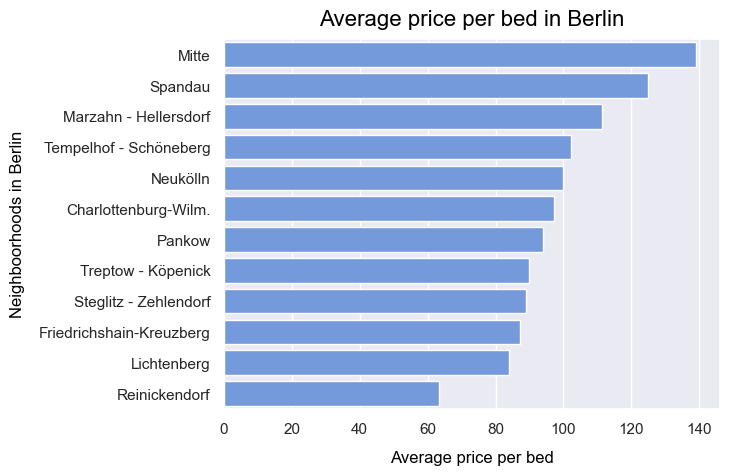

In [103]:
sns.set_theme(style='darkgrid', palette='deep')

fig = sns.barplot(data=df_analyze_q1, y='neighbourhood_group_cleansed', x='price', color='cornflowerblue')
fig.set_title('Average price per bed in Berlin', pad=10, fontsize=16, color='black');
fig.set_xlabel('Average price per bed', fontsize=12, color='black', labelpad=10);
fig.set_ylabel('Neighboorhoods in Berlin', fontsize=12, color='black', labelpad=10);

Question 2: How much are airbnb appartments earing in each neighboorhood over certain timeframes?

Therefore we analyze the availability of all listings in Berlin over several timeframes and invert them to get the current bookings. We can not filter if the hosts did reserve their appartment for their own or blocked the availability for other reasons, but it should give a hint which neighborhoods are the most frequently booked ones and where do hosts make the most profit.

Gather all data of interest out of the main dataframe of all listings, filtered for listings that are marked as 'availale' through the column 'has_availality'.

In [104]:
df_analyze_q2 = df_listing_cleaned.loc[df_listing_cleaned['has_availability'] == 't',['neighbourhood_group_cleansed', 'price', 'availability_30', 'availability_60', 'availability_90', 'availability_365']].copy()

Filter some outliers:
- zero availality over the whole year
- listings where the availabilities for all three timeframes are the same (filter hosts who only open up booking for certain periods of time)

In [105]:
# filter for not listed apartments
df_analyze_q2 = df_analyze_q2[df_analyze_q2.availability_365 != 0].copy()

In [106]:
# filter for listings bookable only for certain periods of time
print(f'Listings only bookable for certain timeframes: {df_analyze_q2.query("availability_30 == availability_60 == availability_90 == availability_365").shape[0]}')
index = df_analyze_q2.query("availability_30 == availability_60 == availability_90 == availability_365").index
df_analyze_q2 = df_analyze_q2.drop(index=index, axis=0).copy()

Listings only bookable for certain timeframes: 572


For the days a listing is allready booked we need to invert the availability over the given timeframes

In [107]:
df_analyze_q2['booked_30'] = 30 - df_analyze_q2.availability_30
df_analyze_q2['booked_60'] = 60 - df_analyze_q2.availability_60
df_analyze_q2['booked_90'] = 90 - df_analyze_q2.availability_90
df_analyze_q2['booked_365'] = 365 - df_analyze_q2.availability_365

And with the number of nights booked we can calculate how much revenue each listing is generating in regarding several timeframes

In [108]:
df_analyze_q2['revenue_30'] = df_analyze_q2.booked_30 * df_analyze_q2.price
df_analyze_q2['revenue_60'] = df_analyze_q2.booked_60 * df_analyze_q2.price
df_analyze_q2['revenue_90'] = df_analyze_q2.booked_90 * df_analyze_q2.price
df_analyze_q2['revenue_365'] = df_analyze_q2.booked_365 * df_analyze_q2.price

In [109]:
df_plot_q2 = df_analyze_q2.melt(
    value_vars=['booked_30','booked_60','booked_90'], 
    id_vars=['neighbourhood_group_cleansed','price'],
    var_name='booking_tf',
    value_name='days_booked'
    ).copy()

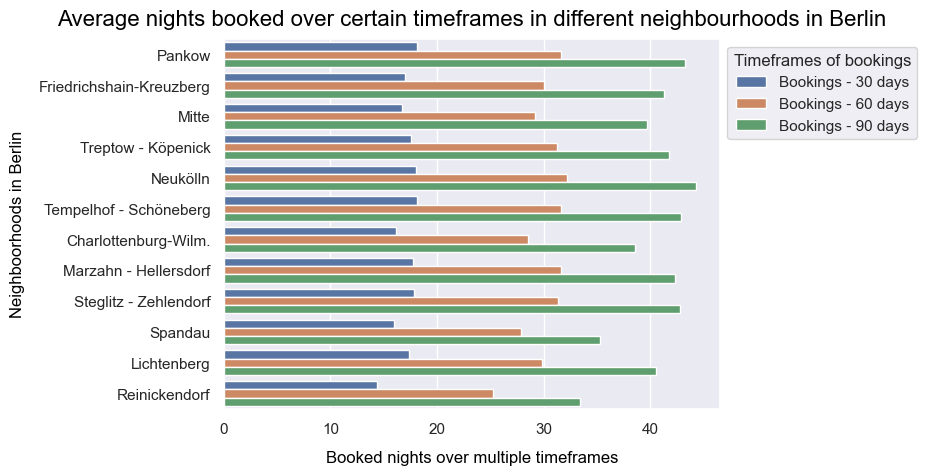

In [110]:
fig = sns.barplot(
    data=df_plot_q2, 
    y='neighbourhood_group_cleansed', 
    x='days_booked', 
    hue='booking_tf', 
    ci=None,
    )
fig.set_title('Average nights booked over certain timeframes in different neighbourhoods in Berlin', pad=10, fontsize=16, color='black'); 
fig.set_xlabel('Booked nights over multiple timeframes', fontsize=12, color='black', labelpad=10);
fig.set_ylabel('Neighboorhoods in Berlin', fontsize=12, color='black', labelpad=10);

fig.legend(loc=1, title='Timeframes of bookings', labels=['Bookings - 30 days','Bookings - 60 days','Bookings - 90 days'])
sns.move_legend(fig, "upper left", bbox_to_anchor=(1, 1))

In [111]:
order = df_analyze_q2.groupby('neighbourhood_group_cleansed')['booked_365'].mean().sort_values(ascending=False).index.to_list()

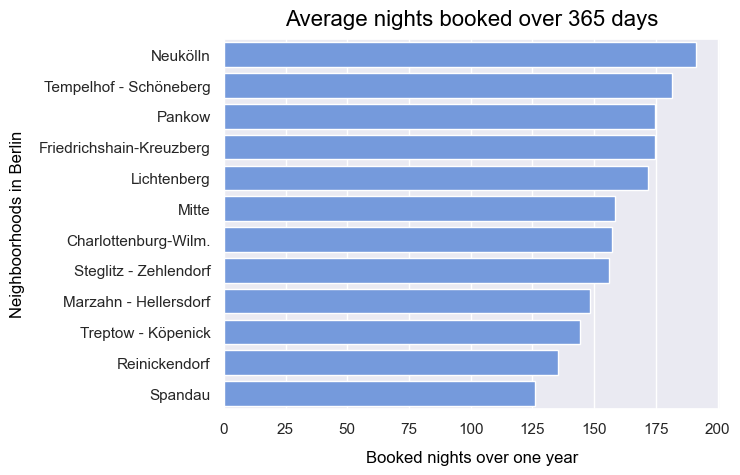

In [112]:
fig = sns.barplot(data=df_analyze_q2, x='booked_365', y='neighbourhood_group_cleansed', ci=None, order=order, color='cornflowerblue')

fig.set_title('Average nights booked over 365 days', pad=10, fontsize=16, color='black'); 
fig.set_xlabel('Booked nights over one year', fontsize=12, color='black', labelpad=10);
fig.set_ylabel('Neighborhoods in Berlin', fontsize=12, color='black', labelpad=10);

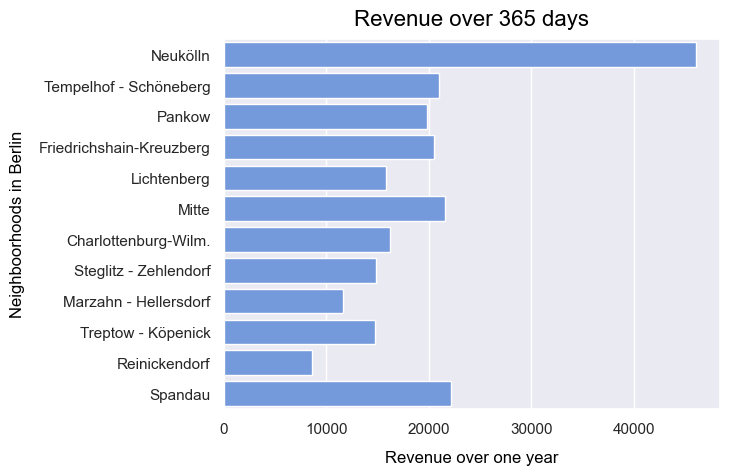

In [113]:
fig = sns.barplot(data=df_analyze_q2, x='revenue_365', y='neighbourhood_group_cleansed', ci=None, order=order, color='cornflowerblue')

fig.set_title('Revenue over 365 days', pad=10, fontsize=16, color='black'); 
fig.set_xlabel('Revenue over one year', fontsize=12, color='black', labelpad=10);
fig.set_ylabel('Neighborhoods in Berlin', fontsize=12, color='black', labelpad=10);

In [114]:
df_analyze_q2.groupby('neighbourhood_group_cleansed')['price'].mean().sort_values(ascending=False)

neighbourhood_group_cleansed
Mitte                       203.292060
Neukölln                    201.233025
Spandau                     138.045872
Marzahn - Hellersdorf       129.690476
Tempelhof - Schöneberg      129.261824
Friedrichshain-Kreuzberg    121.371347
Pankow                      120.018883
Charlottenburg-Wilm.        114.692994
Treptow - Köpenick          110.809524
Steglitz - Zehlendorf       101.441860
Lichtenberg                  96.087963
Reinickendorf                72.081761
Name: price, dtype: float64

In [115]:
df_analyze_q2.groupby('neighbourhood_group_cleansed', as_index=False).aggregate(revenue_365_sum=('revenue_365', 'sum'), listings_count=('neighbourhood_group_cleansed', 'count'))

,neighbourhood_group_cleansed,revenue_365_sum,listings_count
0,Charlottenburg-Wilm.,12704254,785
1,Friedrichshain-Kreuzberg,28808550,1403
2,Lichtenberg,3408955,216
3,Marzahn - Hellersdorf,980961,84
4,Mitte,38854061,1801
5,Neukölln,29878727,648
6,Pankow,24197682,1218
7,Reinickendorf,1371987,159
8,Spandau,2419418,109
9,Steglitz - Zehlendorf,3203708,215
